# AMT Error Matching <a class="tocSkip">

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Creating-dummy-transcription-data" data-toc-modified-id="Creating-dummy-transcription-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Creating dummy transcription data</a></span><ul class="toc-item"><li><span><a href="#Create-a-small-ACME-dataset" data-toc-modified-id="Create-a-small-ACME-dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Create a small ACME dataset</a></span></li><li><span><a href="#Load-the-ACME-Metadata" data-toc-modified-id="Load-the-ACME-Metadata-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load the ACME Metadata</a></span></li><li><span><a href="#Create-parallel-ground-truth-and-&quot;AMT-output&quot;" data-toc-modified-id="Create-parallel-ground-truth-and-&quot;AMT-output&quot;-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Create parallel ground truth and "AMT output"</a></span></li></ul></li><li><span><a href="#Run-the-Measure-Errors-script" data-toc-modified-id="Run-the-Measure-Errors-script-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Run the Measure Errors script</a></span></li><li><span><a href="#Examples" data-toc-modified-id="Examples-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Examples</a></span><ul class="toc-item"><li><span><a href="#Pitch-shift-errors" data-toc-modified-id="Pitch-shift-errors-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Pitch shift errors</a></span></li><li><span><a href="#Time-shift-errors" data-toc-modified-id="Time-shift-errors-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Time shift errors</a></span></li></ul></li><li><span><a href="#Creating-a-Custom-ACME-Dataset-to-match-your-AMT-output" data-toc-modified-id="Creating-a-Custom-ACME-Dataset-to-match-your-AMT-output-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Creating a Custom ACME Dataset to match your AMT output</a></span></li><li><span><a href="#Input-file-types" data-toc-modified-id="Input-file-types-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Input file types</a></span></li><li><span><a href="#Command-line-arguments" data-toc-modified-id="Command-line-arguments-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Command line arguments</a></span></li></ul></div>

We provide the `measure_errors` script to match the proportion of errors present
in a given set of transcriptions.

The script outputs a `config.json` file which can either be passed to the
`make_dataset` script to create a static ACME dataset of the given proportions,
or it can be used to instantiate a `Degrader`, which can create degraded data
on-the-fly.

In [1]:
import json
import os
import shutil
import sys

import pandas as pd
from tqdm import tqdm

from mdtk.degradations import DEGRADATIONS
from mdtk.fileio import csv_to_df
from utils import plot_from_df

# Creating dummy transcription data

## Create a small ACME dataset

We'll first create a small ACME dataset using only the PianoMidi data. We're going to pretend that the degraded output from the dataset is the "transcribed" data you are wanting to match the errors of.

In [2]:
! python ../make_dataset.py --datasets PianoMidi --formats None --no-prompt --seed 42

Setting random seed to 42.
Loading data from downloaders, this could take a while...
Copying midi to /Users/jfowers/.mdtk_cache/PianoMidi/data: 100%|█| 328/328 [00:0
Degrading data: 100%|█████████████████████████| 328/328 [00:05<00:00, 61.36it/s]

========== Finished! ==========

Count of degradations:
	* none: 36
	* pitch_shift: 37
	* time_shift: 37
	* onset_shift: 36
	* offset_shift: 36
	* remove_note: 37
	* add_note: 36
	* split_note: 37
	* join_notes: 36

You will find the generated data at /Users/jfowers/git/midi_degradation_toolkit/docs/acme with subdirectories
	* clean - contains the extracted clean excerpts
	* altered - contains the excerpts altered by the degradations described in metadata.csv

metadata.csv describes:
	* (the id number for) the type of degradation used for the alteration
	* the path for the altered and clean files
	* which split (train, valid, test) the file should be used in
	* in which corpus and on what line the file is located

degradation_ids.csv is a map

## Load the ACME Metadata

We'll need to load the dataset's metadata to get the paths to the clean/degraded files. We'll use the degraded files as the pseudo-transcriptions.

In [3]:
degradation_ids = pd.read_csv(os.path.join('acme', 'degradation_ids.csv'))

metadata = pd.read_csv(os.path.join('acme', 'metadata.csv'))
metadata.head(10)

,altered_csv_path,degraded,degradation_id,clean_csv_path,split
0,altered/PianoMidi/mz_332_2.csv,1,2,clean/PianoMidi/mz_332_2.csv,train
1,altered/PianoMidi/clementi_opus36_1_2.csv,1,7,clean/PianoMidi/clementi_opus36_1_2.csv,valid
2,altered/PianoMidi/rac_op32_13.csv,1,5,clean/PianoMidi/rac_op32_13.csv,train
3,altered/PianoMidi/alb_se4.csv,1,1,clean/PianoMidi/alb_se4.csv,train
4,altered/PianoMidi/chpn_op25_e12.csv,1,3,clean/PianoMidi/chpn_op25_e12.csv,test
5,altered/PianoMidi/muss_8.csv,1,4,clean/PianoMidi/muss_8.csv,train
6,clean/PianoMidi/scn16_7.csv,0,0,clean/PianoMidi/scn16_7.csv,train
7,altered/PianoMidi/mendel_op19_6.csv,1,8,clean/PianoMidi/mendel_op19_6.csv,train
8,altered/PianoMidi/mendel_op30_5.csv,1,6,clean/PianoMidi/mendel_op30_5.csv,train
9,altered/PianoMidi/chpn_op35_1.csv,1,2,clean/PianoMidi/chpn_op35_1.csv,train


## Create parallel ground truth and "AMT output"

In [4]:
trans_dir = os.path.join("error_matching", "trans")
gt_dir = os.path.join("error_matching", "gt")

os.makedirs(trans_dir, exist_ok=True)
os.makedirs(gt_dir, exist_ok=True)

for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):
    shutil.copy(os.path.join('acme', row.clean_csv_path), gt_dir)
    shutil.copy(os.path.join('acme', row.altered_csv_path), trans_dir)

100%|██████████| 328/328 [00:00<00:00, 1025.70it/s]


We now have an adjacent directory `./error_matching` with the expected input to the error matching script. It contains  two directories:
* `gt`: Contains the ground truth clean excerpts.
* `trans`: Contains the "transcribed" excerpts - the output of your AMT system goes here.

Matching ground truth and transcribed files _must_ have the same basename
in their respective directories. The files can be CSV, MIDI, or pickle (see below).

# Run the Measure Errors script

In [5]:
! python ../measure_errors.py --trans error_matching/trans --gt error_matching/gt --excerpt-length 15000 --min-notes 5

100%|█████████████████████████████████████████| 328/328 [00:28<00:00, 11.35it/s]


The `measure_errors` script can be run on full piece transcriptions, so you can set an `excerpt-length` and `min-notes` via command line arguments. In our case, since we are running in only on excerpts, we set the `excerpt-length` to be longer than all of the excerpts, and the minimum number of notes to be smaller than all excerpts.

For the full usage, see below.

The output of the script is a file called `config.json`, it contains the relative proportions of different degradations to apply to match your data:

In [6]:
with open("config.json", "r") as json_file:
    config = json.load(json_file)

print("Degradation probabilities:")
for prob, deg in zip(config['degradation_dist'], DEGRADATIONS.keys()):
    print(f"{deg.rjust(14)}: {prob}")

print()
print(f"Clean_prop: {config['clean_prop']}")

Degradation probabilities:
   pitch_shift: 0.1267123287671233
    time_shift: 0.0136986301369863
   onset_shift: 0.1232876712328767
  offset_shift: 0.1232876712328767
   remove_note: 0.25
      add_note: 0.2773972602739726
    split_note: 0.08561643835616438
    join_notes: 0.11301369863013698

Clean_prop: 0.10975609756097561


Notice that the probabilities are not all `1/9`, as might be expected from the ACME creation.
This is because the measured probabilities only find one possible path from each transcription
to its ground truth. In our case, it seems that many of the `time_shifts` are classified as
a `remove_note` and an `add_note`. For the `measure_errors` script to classify an error as a `time_shift`,
the shift length must be smaller than the duration of the shifted note. Without giving any arguments
to `make_dataset`, this is unlikely.

# Examples

## Pitch shift errors

Let's take a few examples specifically. First, let's pick a random `pitch_shift`, and plot it.

In [7]:
def get_random_dfs(deg_name, metadata):
    deg_id = degradation_ids.loc[degradation_ids["degradation_name"] == deg_name, "id"].values[0]
    meta_df = metadata.loc[metadata["degradation_id"] == deg_id]

    row = meta_df.sample()
    basename = os.path.basename(row["clean_csv_path"].values[0])
    gt_df = csv_to_df(os.path.join(gt_dir, basename))
    trans_df = csv_to_df(os.path.join(trans_dir, basename))

    return gt_df, trans_df

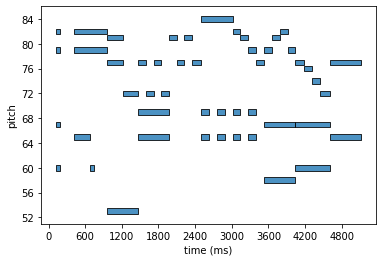

In [8]:
gt_df, trans_df = get_random_dfs("pitch_shift", metadata)

plot_from_df(gt_df)

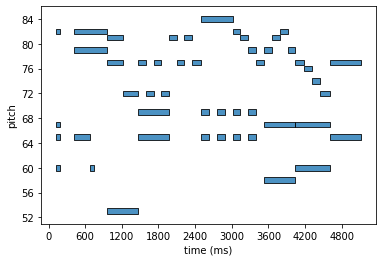

In [9]:
plot_from_df(trans_df)

Now, let's measure the degradation present in the selected excerpt.

In [10]:
sys.path.append("..")
from measure_errors import get_excerpt_degs

deg_counts = get_excerpt_degs(gt_df, trans_df)

print("Degradation counts:")
for count, deg in zip(deg_counts, DEGRADATIONS.keys()):
    print(f"{deg.rjust(14)}: {count}")

Degradation counts:
   pitch_shift: 1.0
    time_shift: 0.0
   onset_shift: 0.0
  offset_shift: 0.0
   remove_note: 0.0
      add_note: 0.0
    split_note: 0.0
    join_notes: 0.0


## Time shift errors

Now we can try the same for `time_shift`:

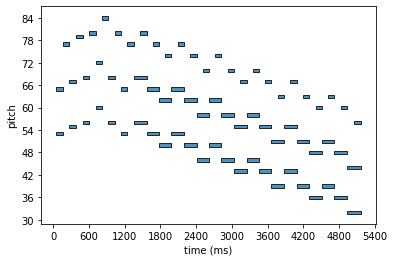

In [11]:
gt_df, trans_df = get_random_dfs("time_shift", metadata)

plot_from_df(gt_df)

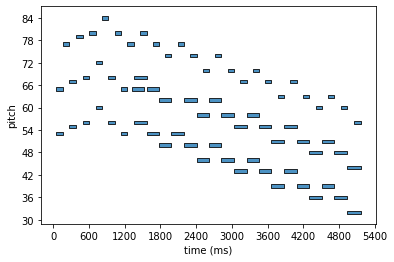

In [12]:
plot_from_df(trans_df)

In [13]:
deg_counts = get_excerpt_degs(gt_df, trans_df)

print("Degradation counts:")
for count, deg in zip(deg_counts, DEGRADATIONS.keys()):
    print(f"{deg.rjust(14)}: {count}")

Degradation counts:
   pitch_shift: 0.0
    time_shift: 0.0
   onset_shift: 0.0
  offset_shift: 0.0
   remove_note: 1.0
      add_note: 1.0
    split_note: 0.0
    join_notes: 0.0


Let's check the time shift length for each of the `time_shift`ed
data points to see if our hypothesis of why they are sometimes missed
is correct.

In [14]:
def get_time_shift_and_dur(gt_df, trans_df):
    merged_df = pd.merge(gt_df, trans_df, how='outer', indicator=True)
    
    orig_note = merged_df.loc[merged_df._merge == "left_only"]
    assert len(orig_note) == 1
    
    degraded_note = merged_df.loc[merged_df._merge == "right_only"]
    assert len(degraded_note) == 1
    
    for col in ["pitch", "dur", "track"]:
        assert orig_note[col].values[0] == degraded_note[col].values[0]
        
    return (
        orig_note["onset"].values[0] - degraded_note["onset"].values[0],
        orig_note["dur"].values[0]
    )

In [15]:
deg_id = degradation_ids.loc[degradation_ids["degradation_name"] == "time_shift", "id"].values[0]
meta_df = metadata.loc[metadata["degradation_id"] == deg_id]

lengths = []
durs = []
degs = []
for _, row in meta_df.iterrows():
    basename = os.path.basename(row["clean_csv_path"])
    gt_df = csv_to_df(os.path.join(gt_dir, basename))
    trans_df = csv_to_df(os.path.join(trans_dir, basename))
    
    length, dur = get_time_shift_and_dur(gt_df, trans_df)
    lengths.append(abs(length))
    durs.append(dur)
    degs.append(get_excerpt_degs(gt_df, trans_df))
    
for length, dur, deg in sorted(list(zip(lengths, durs, degs))):
    print(
        f"Time_shift length = {length}".ljust(27),
        f"duration: {dur}".ljust(15),
        f"degs: {[deg_name for deg_name, deg_flag in zip(DEGRADATIONS, deg) if deg_flag == 1]}",
    )

Time_shift length = 115     duration: 395   degs: ['time_shift']
Time_shift length = 146     duration: 200   degs: ['time_shift']
Time_shift length = 160     duration: 572   degs: ['time_shift']
Time_shift length = 251     duration: 675   degs: ['time_shift']
Time_shift length = 286     duration: 125   degs: ['remove_note', 'add_note']
Time_shift length = 342     duration: 276   degs: ['remove_note', 'add_note']
Time_shift length = 458     duration: 139   degs: ['remove_note', 'add_note']
Time_shift length = 484     duration: 60    degs: ['remove_note', 'add_note']
Time_shift length = 522     duration: 55    degs: ['remove_note', 'add_note']
Time_shift length = 659     duration: 248   degs: ['remove_note', 'add_note']
Time_shift length = 664     duration: 210   degs: ['remove_note', 'add_note']
Time_shift length = 669     duration: 335   degs: ['remove_note', 'add_note']
Time_shift length = 727     duration: 208   degs: ['remove_note', 'add_note']
Time_shift length = 877     duration: 

Notice that every `time_shift` with a length less than the note's `duration`
is classified as a `time_shift`, while longer `time_shifts` are classified
as a `remove_note` and an `add_note`.

# Creating a Custom ACME Dataset to match your AMT output

You can feed the generated `config.json` file to `make_dataset.py` in order to generate a custom ACME dataset matching the measured degradation and clean proportions:

```bash
  python ../make_dataset.py --datasets PianoMidi --no-prompt --seed 42 --config config.json
```

# Input file types

The measure_errors script can read `MIDI`, `CSV`, or `pickle` files:
* `MIDI`: Any MIDI file.
* `CSV`: Any CSV file generated by mdtk (see mdtk/fileio.py).
* `pickle`: A pickle file containing a single numpy array called `piano_roll`, of shape either `num_frames x num_pitches`, or `num_frames x (2 * num_pitches)`, in which case the first `num_pitches` columns are a note presence piano roll and the last `num_pitches` columns are a corresponding onset piano roll. The min and max pitch can be set using `--pr-min-pitch` and `--pr-max-pitch`.

# Command line arguments
The measure_errors script has many other command line arguments. A full list is below, but we will highlight a few of the most useful ones here:

* `--trans` and `--gt`: Directories in which the script will look for matching ground truths and transcriptions. Any files which match in basename (not including extension) will be treated as matches. For example, the ground truth 'file1.mid' will match the transcription 'file1.csv'. Include `-r` to search directories recursively.
* `--trans_start` and `--trans_end`: If the transcriptions are only partial transcriptions of the ground truths, these arguments can be used to set the bounds of the transcriptions (in ms). For example, if only the first 30 seconds are transcribed, use `--trans_end 30000`.
* `--excerpt-length`: Each transcription is split into excerpts of this length before errors are measured. This should be set to the length of excerpt which you plan to send to your model. Shorter values will lead to more accurate error measurements, but longer values may contain long-range patterns that aid in modelling.

In [16]:
! python ../measure_errors.py -h

usage: measure_errors.py [-h] [--json JSON] [-r] --gt GT
                         [--gt_ext {mid,pkl,csv}] --trans TRANS
                         [--trans_ext {mid,pkl,csv}]
                         [--pr-min-pitch PR_MIN_PITCH]
                         [--pr-max-pitch PR_MAX_PITCH]
                         [--trans_start TRANS_START] [--trans_end TRANS_END]
                         [--excerpt-length ms] [--min-notes N]

Measure errors from a transcription error in order to make a degraded MIDI
dataset with the measure proportion of each degration.

optional arguments:
  -h, --help            show this help message and exit
  --json JSON           The file to write the degradation config json data out
                        to.
  -r, --recursive       Search the given --gt and --trans directories
                        recursively. The directory structures in each don't
                        have to be identical, but corresponding files must
                        still be uniquel

In [17]:
# Clean up
! python ../make_dataset.py --no-prompt --clean

shutil.rmtree("acme")
shutil.rmtree("error_matching")
os.remove("config.json")